In [ ]:
import numpy as np
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import cv2
import torch.nn as nn
from torchvision.models import vgg19
import torchvision
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

In [2]:
signlabel =  pd.read_csv(r'/kaggle/input/vietnam-traffic-signs-data-with-harsh-condition/signlabel.csv').drop(['Unnamed: 0'],axis=1)
ids = np.full((signlabel.shape[0]//5,2),'',dtype = '<U30')
ids[:,1] = signlabel.iloc[:signlabel.shape[0]//5,2].str.cat(signlabel.iloc[:signlabel.shape[0]//5,0],sep='/')
ids[:,0] = signlabel.iloc[3*signlabel.shape[0]//5:4*signlabel.shape[0]//5,2].str.cat(signlabel.iloc[3*signlabel.shape[0]//5:4*signlabel.shape[0]//5,0],sep='/')

In [4]:
class Dataset(Dataset):
    '''
    LR = low resolution image
    HR = high resolution image 
    dir = dump of image directories for dataset

    '''
    def __init__(self, ids, lr,hr):
        'Initialization'
        self.dir = ids
        self.lr = lr
        self.hr = hr 
    def __len__(self):
        return len(self.dir)
    def __getitem__(self, index):
        filename = self.dir[index] 
        rain = cv2.imread(self.lr  + filename[0],1)
        origin = cv2.resize(cv2.imread(self.hr + filename[1],1), dsize = (128,128))
        #transpose so pytorch plays nice 
        rain = rain.transpose((2, 0, 1))
        origin= origin.transpose((2, 0, 1))
        stack_2_imgs = np.concatenate([origin,rain],axis = 0)
        
        #pass numpy arrays to torch and make float tensors.
        stack_2_imgs = torch.from_numpy(stack_2_imgs).float()
        crop = torchvision.transforms.RandomResizedCrop(size=64, scale=(0.5,1.0))
        stack_2_imgs = crop(stack_2_imgs)
        origin = stack_2_imgs[:3]
        rain = stack_2_imgs[3:]
        return rain, origin

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features),
            nn.ReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features)
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.conv_block(x)
        out += identity
        out = self.relu(out)
        return self.conv_block(x)

class ScaleLayer(nn.Module):
    def __init__(self, init_value=1e-3):
        super().__init__()
        self.scale = nn.Parameter(torch.FloatTensor([init_value]), requires_grad=True)
        self.shift = nn.Parameter(torch.FloatTensor([init_value]), requires_grad=True)

    def forward(self, input):
        return input * self.scale + self.shift

class Enhance(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, residual_blocks=9):
        super(Enhance, self).__init__()
        self.encode = nn.Sequential(
                        nn.Conv2d(in_channels, 32, kernel_size=7, stride=1, padding=3),
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU())
        #Residual blocks
        residuals = [ResidualBlock(128) for i in range(residual_blocks)]
        self.residuals = nn.Sequential(*residuals)

        #nearest neighbor upsample 
        self.decode = nn.Sequential(
                    nn.Upsample(scale_factor=2, mode='bicubic'),
                    nn.Conv2d(128,64, kernel_size=3, padding=1, padding_mode='replicate'),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.Upsample(scale_factor=2, mode='bicubic'),
                    nn.Conv2d(64,32, kernel_size=3, padding=1, padding_mode='replicate'),
                    nn.BatchNorm2d(32),
                    nn.ReLU(),
                    nn.Conv2d(32, 3, kernel_size=7, stride=1, padding=3),
                    nn.BatchNorm2d(3),
                    nn.Tanh())
        
        self.scale = ScaleLayer()

    def forward(self, x):
        out = self.encode(x)
        out = self.residuals(out)
        out= self.decode(out)
        out = self.scale(out)
        out = torch.add(x ,out)
        return out


In [30]:
epoch_number = 0
loss_thr_epochs = [[],[]]
best_vloss = 1_000_000
best_epoch = 0

In [8]:
! mkdir /kaggle/temp

In [31]:
#hyperparams 
cuda = torch.cuda.is_available()
#torch.cuda.empty_cache()
height = 64
width = 64
channels = 3
lr = .0180
b1 = .5 
b2 = .9
batch_size = 183
n_epochs= 40
hr_shape = (height, width)

save_interval = 50

#build models 
enhance = Enhance(residual_blocks=10)
#send to gpu 
enhance = enhance.cuda()
loss = torch.nn.L1Loss().cuda()

#set optimizers 
e_opti = torch.optim.Adam(enhance.parameters(), lr=lr, betas=(b1, b2))

#set data geneator 
imagedir = ids
rains = "/kaggle/input/vietnam-traffic-signs-data-with-harsh-condition/Traffic Signs Data/Traffic Signs Data Rain/"
origs = "/kaggle/input/vietnam-traffic-signs-data-with-harsh-condition/Traffic Signs Data/Traffic Signs Data/"
gen = Dataset(ids = imagedir, lr = rains, hr = origs)
trainset, valset = random_split(gen, [0.8,0.2],torch.Generator().manual_seed(42))
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=0)
#train_loader = iter(train_loader)

In [ ]:
# load_weights = True

if load_weights:
    print("Loading old weights...")
    tmp = torch.load("/kaggle/working/enhance_rain.pth")
    enhance.load_state_dict(tmp)
    print("Best old weights loaded!")

Tensor = torch.cuda.FloatTensor

print('Batches num',len(train_loader))


for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    for i, (lr, hr) in enumerate(train_loader):
        enhance.train()
        #Variables so torch plays nice with autograd
        lr = Variable(lr.type(Tensor))
        hr = Variable(hr.type(Tensor))

        '''Enhance'''

        #reset grads 
        e_opti.zero_grad()

        #enhance
        enhanced_hr = enhance(lr)

        #fetch loss

        e_loss = loss(enhanced_hr, hr)

        #backpop that loss
        e_loss.backward()
        #update our optimizer 
        e_opti.step()

        print("%i" %(i), end=" ")
        train_loss += e_loss.item()
    with torch.no_grad():
        for j, (lr, hr) in enumerate(val_loader):
            enhance.eval()
            lr = Variable(lr.type(Tensor))
            hr = Variable(hr.type(Tensor))
            enhanced_hr = enhance(lr)
            vloss = loss(enhanced_hr, hr)
            val_loss += vloss.item()

        epoch_number += 1
        print()
        print("Train loss: %f \t Val loss: %f \t Epoch: %i" %(train_loss/(i+1), val_loss/(j+1), epoch_number))
        #put the channels back in order!
        loss_thr_epochs[0].append(train_loss)
        loss_thr_epochs[1].append(val_loss)
        if val_loss < best_vloss:
            best_epoch = epoch_number
            best_vloss = val_loss
            torch.save(enhance.state_dict(), "/kaggle/working/enhance_rain_vgg.pth")
        

print(best_epoch)

lr = lr[:12, [2,1,0]]
enhanced_hr = enhanced_hr[:12, [2,1,0]]
hr = hr[:12, [2,1,0]]
#fancy grid so we can view
enhanced_hr = make_grid(enhanced_hr, nrow=1, normalize=True)
hr = make_grid(hr, nrow=1, normalize=False)/255
lr = make_grid(lr, nrow=1, normalize=False)/255
tmp = torch.cat((hr, enhanced_hr, lr), -1)
save_image(tmp, "/kaggle/temp/%d.png" % epoch, normalize=False)

Loading old weights...
Best old weights loaded!
Batches num 16
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Train loss: 9.609712 	 Val loss: 13.075085 	 Epoch: 1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Train loss: 9.438703 	 Val loss: 13.426248 	 Epoch: 2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Train loss: 9.323463 	 Val loss: 13.149316 	 Epoch: 3
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Train loss: 9.246768 	 Val loss: 14.634858 	 Epoch: 4
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Train loss: 9.197280 	 Val loss: 14.123750 	 Epoch: 5
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Train loss: 9.157592 	 Val loss: 14.628891 	 Epoch: 6
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Train loss: 9.142759 	 Val loss: 13.704761 	 Epoch: 7
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Train loss: 9.105094 	 Val loss: 13.589079 	 Epoch: 8
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Train loss: 9.082956 	 Val loss: 13.452339 	 Epoch: 9
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Train loss: 9.020957 	 Val loss: 13.186778 	 Epoch: 10
0 1 2 

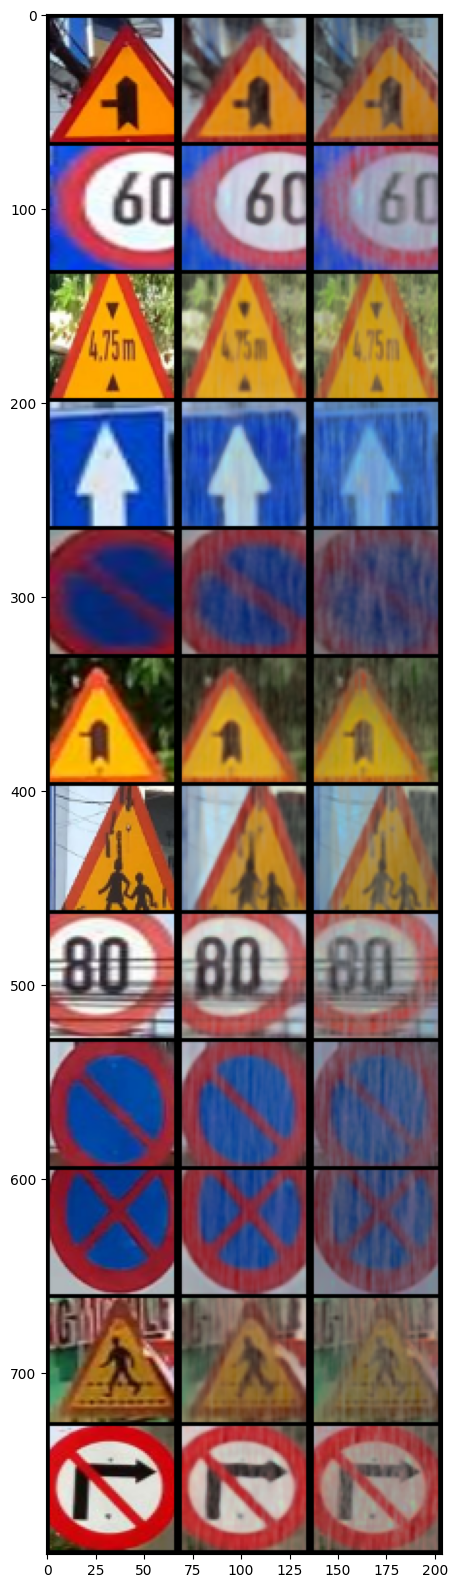

In [24]:
img = cv2.imread('/kaggle/temp/19.png')
plt.figure(figsize=(10,20))
plt.imshow(img[:,:,::-1])